In [1]:
import pandas as pd
from csvCreator import get_readable_date
import numpy as np

In [2]:
def to_evenly_spaced(df):
    df.drop(['phq_2'], axis=1, inplace=True)
    date = df['time'].apply(lambda x: get_readable_date(x))
    df.insert(loc=1, column='date', value=date)
    median = np.trunc(df.groupby('date').size().median())
    df.drop(['date'], axis=1, inplace=True)
    day = np.trunc(len(df.index) / median)
    new_last_index = int(median * day)

    even_time = []
    firs_time = df[['time']].iloc[1].values.item()
    for i in range(len(df.index)):
        even_time.append(firs_time)
        firs_time += 60
    df.drop(['time'], axis=1, inplace=True)
#     df.insert(loc=0, column='time', value=even_time)
    df = df.iloc[:new_last_index]
    return df, int(median)

In [3]:
def generator(data, look_b, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + look_b
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + look_b, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + look_b
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           look_b // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - look_b, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][-1]
        yield samples, targets


In [4]:
output_path = '/Volumes/hex/ST-1233329802-res/'
p_802 = pd.read_csv(output_path + 'ST-1233329802_3.0.csv')

# just numerical data
p_802 = p_802.drop(['date', 'window'], axis=1)
p_802, median = to_evenly_spaced(p_802)

In [5]:
median

452

In [7]:
float_data = p_802.to_numpy()

# first 200 days as training
mean = float_data[:90400].mean(axis=0)
float_data -= mean
std = float_data[:90400].std(axis=0)
float_data /= std

In [8]:
# assume each day got 408 value (average value) that means 17 value per Hour.
# most probably will be 3
step = int(np.trunc(60 / (median / 24)))
# observations will look back 7 days (average)
look_back = step * 7 * 24
delay = 24 * step

# one day
batch_size = median

In [9]:
step

3

In [10]:
float_data.shape

(122040, 26)

In [11]:
look_back

504

In [12]:
float_data[0]

array([-1.22544612,  5.71048722, -0.6541132 ,  2.98587402, -0.21903021,
        2.98587402, -7.75446454,  6.0399647 , -9.30654744,  6.05167197,
       -1.92787682,  6.82925229, -1.37115884, 19.05504734, -2.70913572,
       -2.04544979, -2.10834643,  0.07319007, -0.26389235,  1.28103953,
       -0.45232897, -0.38280431, -0.19601194, -1.24393266,  1.37002538,
       -0.84318036])

In [13]:
train_gen = generator(float_data,
                      look_b=look_back,
                      delay=delay,
                      min_index=0,
                      max_index=90400,
                      shuffle=False,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(float_data,
                    look_b=look_back,
                    delay=delay,
                    min_index=90401,
                    max_index=108480,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     look_b=look_back,
                     delay=delay,
                     min_index=108481,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)


In [14]:
val_steps = (108480 - 90401 - look_back)
test_steps = (len(float_data) - 108481 - look_back)
# temp = (108480 - 90400)/batch_size

In [15]:
val_steps

17575

In [16]:
samples1, targets1 = next(train_gen)
samples2, targets2 = next(val_gen)
samples3, targets3 = next(test_gen)


In [17]:
samples1.shape

(452, 168, 26)

In [24]:
targets1

array([-0.08496386, -0.08496386, -0.08496386, -0.08496386, -0.08496386,
       -0.08496386, -0.08496386, -0.08496386, -0.08496386, -0.08496386,
       -0.08496386, -0.08496386, -0.08496386, -0.08496386, -0.08496386,
       -0.08496386, -0.08496386, -0.08496386, -0.08496386, -0.08496386,
       -0.08496386, -0.08496386, -0.08496386, -0.08496386, -0.08496386,
       -0.08496386, -0.08496386, -0.08496386, -0.08496386, -0.08496386,
       -0.08496386, -0.08496386, -0.08496386, -0.08496386, -0.08496386,
       -0.08496386, -0.08496386, -0.08496386, -0.08496386, -0.08496386,
       -0.08496386, -0.08496386, -0.08496386, -0.08496386, -0.08496386,
       -0.08496386, -0.08496386, -0.08496386, -0.08496386, -0.08496386,
       -0.08496386, -0.08496386, -0.08496386, -0.08496386, -0.08496386,
       -0.08496386, -0.08496386, -0.08496386, -0.08496386, -0.08496386,
       -0.08496386, -0.08496386, -0.08496386, -0.08496386, -0.08496386,
       -0.08496386, -0.08496386, -0.08496386, -0.08496386, -0.08

In [19]:
samples2.shape

(452, 168, 26)

In [20]:
samples3.shape

(452, 168, 27)

In [18]:
def evaluate_naive_model():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

In [ ]:
# evaluate_naive_model()
# = 1.04

# First RNN Model

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

In [40]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimzer=RMSprop(), loss='mae')
history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=temp)


Train for 500 steps, validate for 40.0 steps
Epoch 1/20
500/500 [==============================] - 145s 291ms/step - loss: 0.8039 - val_loss: 0.8400
Epoch 2/20
500/500 [==============================] - 146s 292ms/step - loss: 0.7452 - val_loss: 0.8580
Epoch 3/20
500/500 [==============================] - 144s 288ms/step - loss: 0.7013 - val_loss: 0.8630
Epoch 4/20
500/500 [==============================] - 144s 288ms/step - loss: 0.6755 - val_loss: 0.8810
Epoch 5/20
500/500 [==============================] - 140s 280ms/step - loss: 0.6519 - val_loss: 0.8864
Epoch 6/20
500/500 [==============================] - 142s 283ms/step - loss: 0.6302 - val_loss: 0.8911
Epoch 7/20
500/500 [==============================] - 140s 280ms/step - loss: 0.6127 - val_loss: 0.8831
Epoch 8/20
500/500 [==============================] - 139s 279ms/step - loss: 0.5956 - val_loss: 0.8891
Epoch 9/20
500/500 [==============================] - 141s 283ms/step - loss: 0.5803 - val_loss: 0.8975
Epoch 10/20
500/500

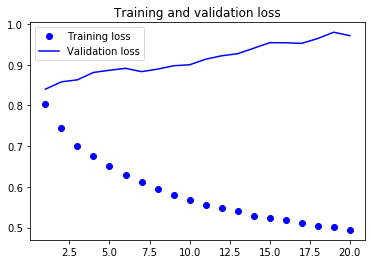

In [46]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [23]:
step = int(np.trunc(60 / (median / 24)))
# observations will look back 7 days (average)
look_back = step * 7 * 24
delay = 24 * step

# one day
batch_size = median

In [24]:
model_2 = Sequential()
model_2.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model_2.add(layers.MaxPooling1D(3))
model_2.add(layers.Conv1D(32, 5, activation='relu'))
model_2.add(layers.MaxPooling1D(3))
model_2.add(layers.Conv1D(32, 5, activation='relu'))
model_2.add(layers.GlobalMaxPooling1D())
model_2.add(layers.Dense(1))

model_2.compile(optimizer=RMSprop(), loss='mae')
history_2 = model_2.fit(train_gen,
                        steps_per_epoch=500,
                        epochs=20,
                        validation_data=val_gen,
                        validation_steps=temp)

Train for 500 steps, validate for 40.0 steps
Epoch 1/20
500/500 [==============================] - 53s 107ms/step - loss: 0.7838 - val_loss: 0.8856
Epoch 2/20
500/500 [==============================] - 54s 109ms/step - loss: 0.7140 - val_loss: 0.8785
Epoch 3/20
500/500 [==============================] - 54s 108ms/step - loss: 0.6820 - val_loss: 0.9162
Epoch 4/20
500/500 [==============================] - 53s 107ms/step - loss: 0.6572 - val_loss: 0.8975
Epoch 5/20
500/500 [==============================] - 58s 116ms/step - loss: 0.6375 - val_loss: 0.9225
Epoch 6/20
500/500 [==============================] - 59s 118ms/step - loss: 0.6229 - val_loss: 0.9251
Epoch 7/20
500/500 [==============================] - 57s 115ms/step - loss: 0.6102 - val_loss: 0.9375
Epoch 8/20
500/500 [==============================] - 58s 115ms/step - loss: 0.5995 - val_loss: 0.9264
Epoch 9/20
500/500 [==============================] - 58s 117ms/step - loss: 0.5892 - val_loss: 0.9497
Epoch 10/20
500/500 [=======

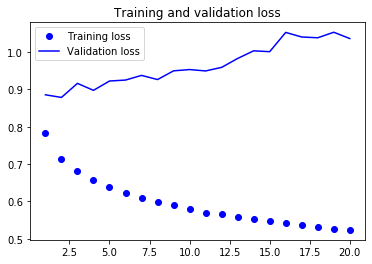

In [27]:
import matplotlib.pyplot as plt
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [37]:

model_3 = Sequential()
model_3.add(layers.Conv1D(32, 5, activation='relu',
                          input_shape=(None, float_data.shape[-1])))
model_3.add(layers.MaxPooling1D(3))
model_3.add(layers.Conv1D(32, 5, activation='relu'))
model_3.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.3))
model_3.add(layers.Dense(1))

model_3.summary()
model_3.compile(optimizer=RMSprop(), loss='mae')
history_3 = model_3.fit(train_gen,
                        steps_per_epoch=500,
                        epochs=20,
                        validation_data=val_gen,
                        validation_steps=temp)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, None, 32)          4352      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, None, 32)          0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 15,873
Trainable params: 15,873
Non-trainable params: 0
_________________________________________________________________
Train for 500 steps, validate for 40.0 steps
Epoch 1/20
500/500 [==============================] - 103s 206ms/step -

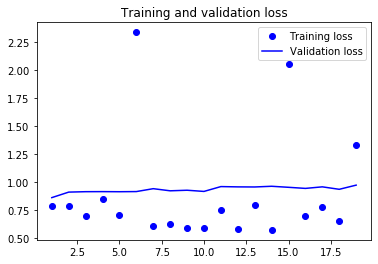

In [39]:
loss = history_3.history['loss'][1:]
val_loss = history_3.history['val_loss'][1:]

epochs = range(1, len(loss) + 1)
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()